# 1. 载入数据

首先记得指明你的data_dir：

In [1]:
data_dir = './data/Aluminum/'

In [2]:
import tensorflow

In [3]:
import os
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *

In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.applications import imagenet_utils

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

读取子文件的名称作为真实的类别标签：

In [7]:
os.listdir(data_dir)

['blister',
 'bump',
 'coating_crack',
 'convexity',
 'damage',
 'dirty_spot',
 'indentation',
 'jet_flow',
 'orange_peel',
 'rub_mark']

In [8]:
labels = os.listdir(data_dir)

然后可以读取子文件夹里面的每张图片作为输入：

In [9]:
os.path.join(data_dir, labels[0])

'./data/Aluminum/blister'

In [10]:
os.listdir(os.path.join(data_dir, labels[0]))

['blister_1.jpg',
 'blister_10.jpg',
 'blister_11.jpg',
 'blister_12.jpg',
 'blister_13.jpg',
 'blister_14.jpg',
 'blister_15.jpg',
 'blister_16.jpg',
 'blister_17.jpg',
 'blister_18.jpg',
 'blister_19.jpg',
 'blister_2.jpg',
 'blister_20.jpg',
 'blister_21.jpg',
 'blister_22.jpg',
 'blister_3.jpg',
 'blister_4.jpg',
 'blister_5.jpg',
 'blister_6.jpg',
 'blister_7.jpg',
 'blister_8.jpg',
 'blister_9.jpg']

记录对应的图片完整路径和对应的标签：

In [11]:
X_list = []
y_list = []
labels = os.listdir(data_dir)
for label in labels:
    label_path = os.path.join(data_dir, label)
    fns = os.listdir(label_path)
    for fn in fns:
        X_list.append(os.path.join(label_path, fn))
        y_list.append(label)

In [12]:
X_list[:5]

['./data/Aluminum/blister\\blister_1.jpg',
 './data/Aluminum/blister\\blister_10.jpg',
 './data/Aluminum/blister\\blister_11.jpg',
 './data/Aluminum/blister\\blister_12.jpg',
 './data/Aluminum/blister\\blister_13.jpg']

In [13]:
y_list[:5]

['blister', 'blister', 'blister', 'blister', 'blister']

In [14]:
X_list[-5:]

['./data/Aluminum/rub_mark\\rub_mark_5.jpg',
 './data/Aluminum/rub_mark\\rub_mark_6.jpg',
 './data/Aluminum/rub_mark\\rub_mark_7.jpg',
 './data/Aluminum/rub_mark\\rub_mark_8.jpg',
 './data/Aluminum/rub_mark\\rub_mark_9.jpg']

In [15]:
y_list[-5:]

['rub_mark', 'rub_mark', 'rub_mark', 'rub_mark', 'rub_mark']

In [16]:
len(X_list)

372

In [17]:
len(y_list)

372

转换为DataFrame的格式：

In [18]:
import pandas as pd
df = pd.DataFrame({'X': X_list, 'y_name': y_list}, index=range(len(X_list)))

In [19]:
df.head()

,X,y_name
0,./data/Aluminum/blister\blister_1.jpg,blister
1,./data/Aluminum/blister\blister_10.jpg,blister
2,./data/Aluminum/blister\blister_11.jpg,blister
3,./data/Aluminum/blister\blister_12.jpg,blister
4,./data/Aluminum/blister\blister_13.jpg,blister


将类别名称进行编码：

In [20]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['y'] = encoder.fit_transform(df['y_name'])

In [21]:
df.head()

,X,y_name,y
0,./data/Aluminum/blister\blister_1.jpg,blister,0
1,./data/Aluminum/blister\blister_10.jpg,blister,0
2,./data/Aluminum/blister\blister_11.jpg,blister,0
3,./data/Aluminum/blister\blister_12.jpg,blister,0
4,./data/Aluminum/blister\blister_13.jpg,blister,0


In [22]:
max(df['y'])

9

一共9+1=10种类别。

In [23]:
num_classes = max(df['y']) + 1

In [24]:
num_classes

10

因此这个问题我们要处理的是一个10-分类问题。

接下来进行数据集的划分：

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# 按照y进行分层采样
# 20%的数据作为测试集
for train_index, test_index in split.split(df, df['y']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [26]:
strat_train_set.shape

(297, 3)

In [27]:
strat_test_set.shape

(75, 3)

In [28]:
strat_train_set.head()

,X,y_name,y
97,./data/Aluminum/convexity\convexity_2.jpg,convexity,3
317,./data/Aluminum/orange_peel\orange_peel_23.jpg,orange_peel,8
345,./data/Aluminum/orange_peel\orange_peel_8.jpg,orange_peel,8
287,./data/Aluminum/jet_flow\jet_flow_34.jpg,jet_flow,7
106,./data/Aluminum/convexity\convexity_28.jpg,convexity,3


接下来利用ImageDataGenerator来准备训练用的generator

In [29]:
# 图像归一化
# 并且划分20%的训练集数据作为验证集数据
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# 设置小批量的大小
batch_size = 8
# 统一图片的分辨率
target_size = (256, 256)

# 我们的dataframe中保存的路径足够
# 否则还需要指明directory来表示文件存放的路径
train_generator=datagen.flow_from_dataframe(dataframe=strat_train_set, 
                                            x_col='X',
                                            y_col='y',
                                            subset="training",
                                            seed=44,  # 随机数种子
                                            # class_mode="sparse", # 直接使用文本标签
                                            class_mode='raw',  # 用整数标签
                                            target_size=target_size,  # 这里把图片调整大小
                                            batch_size=batch_size) # 内存不足可以调小batch_size

# 划分验证集
valid_generator=datagen.flow_from_dataframe(dataframe=strat_train_set, 
                                            x_col='X',
                                            y_col='y',
                                            subset="validation",
                                            seed=44,  # 随机数种子
                                            # class_mode="sparse", # 直接使用文本标签
                                            class_mode='raw',  # 用整数标签
                                            target_size=target_size,  # 这里把图片调整大小
                                            batch_size=batch_size) # 内存不足可以调小batch_size

Found 238 validated image filenames.
Found 59 validated image filenames.


分别查看训练集和验证集的数据量：

In [30]:
train_generator.n

238

In [31]:
train_generator.batch_size

8

In [32]:
valid_generator.n

59

In [33]:
valid_generator.batch_size

8

In [34]:
for X_batch, y_batch in train_generator:
    print(X_batch.shape)
    print(y_batch.shape)
    break

(8, 256, 256, 3)
(8,)


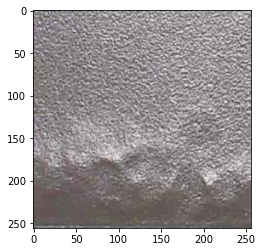

In [35]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X_batch[0])

In [36]:
y_batch[0]

3

可以看到已经train_generator已经可以自动读取图像了

类似的，我们构建test_generator

In [37]:
# 图像归一化
datagen=ImageDataGenerator(rescale=1./255)

# 我们的dataframe中保存的路径足够
# 否则还需要指明directory来表示文件存放的路径
test_generator=datagen.flow_from_dataframe(dataframe=strat_test_set, 
                                            x_col='X',
                                            y_col='y',
                                            # class_mode="sparse", # 直接使用文本标签
                                            class_mode='raw',  # 用整数标签
                                            target_size=target_size,  # 这里把图片调整大小
                                            batch_size=batch_size) # 内存不足可以调小batch_size

Found 75 validated image filenames.


In [38]:
test_generator.n

75

In [39]:
test_generator.batch_size

8

In [40]:
num_classes = 10
input_shape = (256, 256, 3)

# 配置模型参数

In [41]:
learning_rate = 0.0001
weight_decay = 0.001
batch_size = 8
num_epochs = 30
image_size = 256  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [256, 128]  # Size of the dense layers of the final classifier

实现模型：

In [42]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [43]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(-0.5, 255.5, 255.5, -0.5)

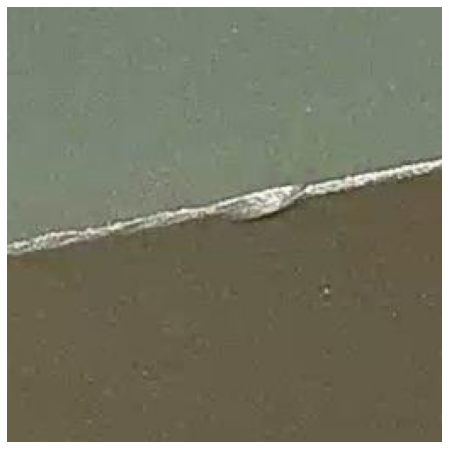

In [44]:
plt.figure(figsize=(8, 8))
image = X_batch[4] * 255
plt.imshow(image.astype("uint8"))
plt.axis("off")

Image size: 256 X 256
Patch size: 16 X 16
Patches per image: 256
Elements per patch: 768


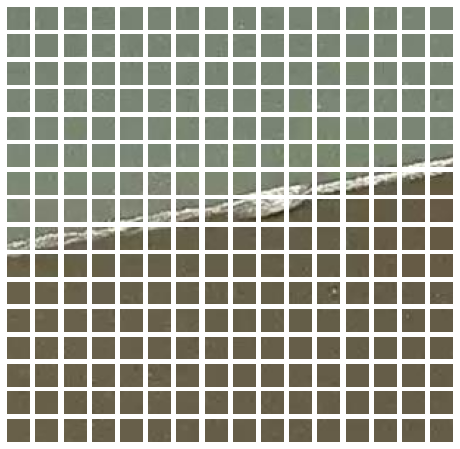

In [45]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [46]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [47]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [48]:
model = create_vit_classifier()

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 patches_1 (Patches)            (None, None, 768)    0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 256, 64)      65600       ['patches_1[0][0]']              
                                                                                                  
 layer_normalization (LayerNorm  (None, 256, 64)     128         ['patch_encoder[0][0]']      

 eadAttention)                                                    'layer_normalization_6[0][0]']  
                                                                                                  
 add_6 (Add)                    (None, 256, 64)      0           ['multi_head_attention_3[0][0]', 
                                                                  'add_5[0][0]']                  
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 256, 64)     128         ['add_6[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_7 (Dense)                (None, 256, 128)     8320        ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_6

 dropout_13 (Dropout)           (None, 256, 64)      0           ['dense_14[0][0]']               
                                                                                                  
 add_13 (Add)                   (None, 256, 64)      0           ['dropout_13[0][0]',             
                                                                  'add_12[0][0]']                 
                                                                                                  
 layer_normalization_14 (LayerN  (None, 256, 64)     128         ['add_13[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_7 (MultiH  (None, 256, 64)     66368       ['layer_normalization_14[0][0]', 
 eadAttention)                                                    'layer_normalization_14[0][0]'] 
          

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001,decay = 0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 30
batch_size = 8

history0 = model.fit(train_generator,
          steps_per_epoch=train_generator.n // train_generator.batch_size,
          validation_data=valid_generator,
          validation_steps=valid_generator.n // valid_generator.batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/30
29/29 [==============================] - 27s 307ms/step - loss: 3.4046 - accuracy: 0.3696 - val_loss: 2.1141 - val_accuracy: 0.4464
Epoch 2/30
29/29 [==============================] - 4s 142ms/step - loss: 0.9388 - accuracy: 0.7087 - val_loss: 1.3806 - val_accuracy: 0.5179
Epoch 3/30
29/29 [==============================] - 4s 141ms/step - loss: 0.5524 - accuracy: 0.8174 - val_loss: 1.3510 - val_accuracy: 0.5357
Epoch 4/30
29/29 [==============================] - 4s 147ms/step - loss: 0.3208 - accuracy: 0.9087 - val_loss: 1.4131 - val_accuracy: 0.5357
Epoch 5/30
29/29 [==============================] - 4s 147ms/step - loss: 0.3377 - accuracy: 0.8783 - val_loss: 0.9949 - val_accuracy: 0.7500
Epoch 6/30
29/29 [==============================] - 4s 145ms/step - loss: 0.2431 - accuracy: 0.8957 - val_loss: 0.6160 - val_accuracy: 0.8214
Epoch 7/30
29/29 [==============================] - 4s 142ms/step - loss: 0.1855 - accuracy: 0.9261 - val_loss: 0.5265 - val_accuracy: 0.8929
Epoch

我们在测试集上进行评估：

In [52]:
loss, acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
acc

9/9 [==============================] - 0s 40ms/step - loss: 0.3424 - accuracy: 0.9306


0.9305555820465088

可以画出训练过程：

In [53]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['font.size'] = 20

In [54]:
def plot_training(history, save_fn):
    import pandas as pd
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=[12, 9])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
             label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
             label = 'Validation Accuracy')
    plt.legend()
    
    plt.savefig(save_fn, dpi=400, bbox_inches='tight')

In [55]:
def plot_training_loss(history, save_fn):
    import pandas as pd
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=[12, 9])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],
             label = 'Validation Loss')
    plt.legend()
    
    plt.savefig(save_fn, dpi=400, bbox_inches='tight')

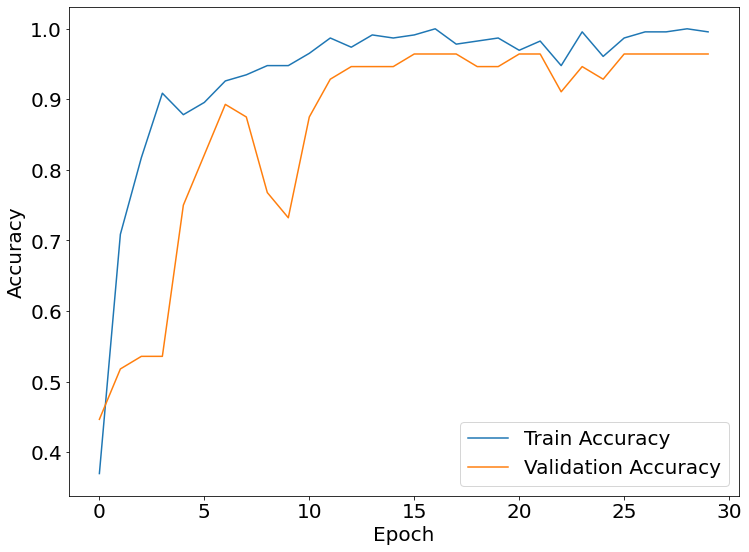

In [56]:
plot_training(history0, 'training.png')

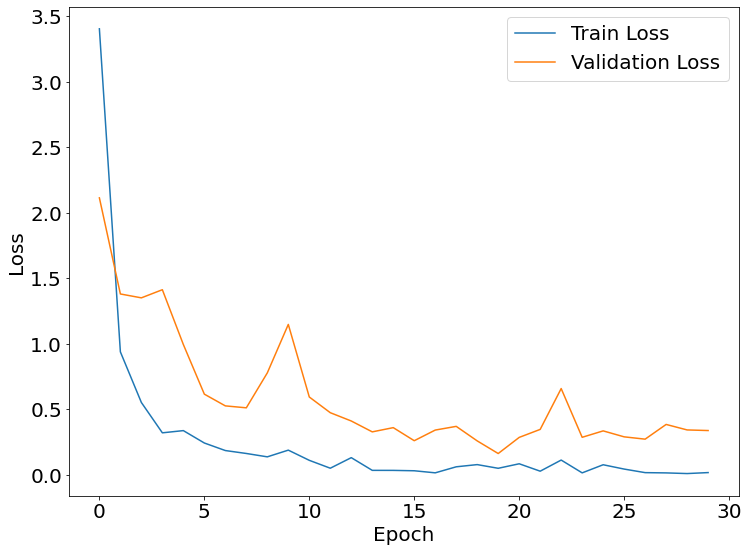

In [57]:
plot_training_loss(history0, 'loss.png')

# 进一步评估结果

获取测试集上的真实标签：

In [58]:
y_true = strat_test_set['y'].values
y_true[:5]

array([8, 0, 7, 2, 5])

获取测试集上的预测标签：

In [59]:
import numpy as np

y_pred_proba = []
y_pred = []
for fn in strat_test_set['X'].values:
    img = load_img(fn, target_size=(256, 256))
    img = img_to_array(img)
    img = img / 255.  # rescale
    img = np.expand_dims(img, axis=0)
    pred_proba = model.predict(img, verbose=0)[0]
    y_pred_proba.append(pred_proba)
    pred = np.argmax(pred_proba)
    y_pred.append(pred)

In [60]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import seaborn as sn
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

查看classification report：

In [61]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.86      1.00      0.92         6
           2       1.00      1.00      1.00         7
           3       1.00      0.89      0.94         9
           4       1.00      0.86      0.92         7
           5       0.80      0.89      0.84         9
           6       1.00      0.90      0.95        10
           7       0.90      1.00      0.95         9
           8       1.00      1.00      1.00         9
           9       1.00      0.80      0.89         5

    accuracy                           0.93        75
   macro avg       0.94      0.93      0.93        75
weighted avg       0.94      0.93      0.93        75



In [62]:
f1_score(y_true, y_pred, average='macro')

0.9301950199783018

In [63]:
accuracy_score(y_true, y_pred)

0.9333333333333333